/home/deep_learning/yanjing/idea6/script
start:1698485313.2848005
Enclosing subgraph extraction begins...


6248iteration [01:33, 67.04iteration/s]


# test: 6248
linegraphs extraction begins.........


100%|██████████| 6248/6248 [00:27<00:00, 228.14iteration/s]
/home/deep_learning/anaconda3/envs/tf36/lib/python3.6/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


load model


100%|██████████| 49/49 [00:02<00:00, 22.03batch/s]


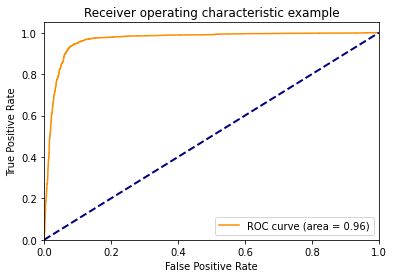

average test : loss 0.22851 
TN:2912,TP:2845,FP:212,FN:279
ACC:0.921414852142334, PRE:0.9306509494781494, SEN:0.9106914401054382, SPE:0.9321382641792297, MCC:0.8430236577987671,F1:0.9205629825592041,AUC:0.964853234469089,AUPR:0.9522123169024752
total 125.55182433128357 seconds


In [11]:
# %load indenpendent_test.py
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import array
import sys, copy, math, time, pdb
import os
os.getcwd()
print(os.getcwd())
os.chdir('/home/deep_learning/yanjing/idea6/script')
import os.path as osp
import random
import argparse
import networkx as nx
from scipy import interp
from util_functions import *
from torch_geometric.data import DataLoader
from model import Net
from itertools import chain
from torch.optim import *
from sklearn import metrics
from sklearn.metrics import average_precision_score,precision_recall_curve,roc_curve, auc
from openpyxl import load_workbook
import gc
import pandas as pd
from sklearn.model_selection import StratifiedKFold,train_test_split,KFold
from pytorchtools import EarlyStopping

def parse_args():
    parser = argparse.ArgumentParser(description='Link Prediction')
    # general settings
    parser.add_argument('--dataset', default='NPInter', help='network name')  #7:3
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--initialLearningRate', default=0.0001,type=float, help='Initial learning rate')
    parser.add_argument('--l2WeightDecay', default=0.001, type=float, help='L2 weight')
    parser.add_argument('--epochNumber', default=60,type=int, help='number of training epoch')
    parser.add_argument('--batchSize', default=128, type=int, help='batch size')

    # model settings
    parser.add_argument('--hop', default=2, metavar='S',
                        help='enclosing subgraph hop number, \
                        options: 1, 2,..., "auto"')
    parser.add_argument('--max-nodes-per-hop', default=50,
                        help='if > 0, upper bound the # nodes per hop by subsampling')
    args, unknown = parser.parse_known_args()
    # return parser.parse_args()
    return args



def links_subgraphs(A, temp_test_data ,temp_test_label,node_feature):
    def helper(A, links, g_labels):
        '''
        g_list = []
        for i, j in tqdm(zip(links[0], links[1])):
            g, n_labels, n_features = subgraph_extraction_labeling((i, j), A, h, max_nodes_per_hop, node_information) #提取子图
            max_n_label['value'] = max(max(n_labels), max_n_label['value'])
            g_list.append(GNNGraph(g, g_label, n_labels, n_features)) #把这些得到的子图都放进图列表里
        return g_list
        '''

        pbar = tqdm(zip(links[0],links[1],g_labels),unit = 'iteration')
        results_list = []
        for i,j ,z in pbar:
            ind = (i ,j)
            g_label = z
            results = subgraph_extraction_labeling(ind, A, g_label,node_feature,h=2, max_nodes_per_hop = 30)
            if results is not None:
                results_list.append(results)
            else:
                pass

        graph_list = []
        for g,g_label, n_labels, n_features in results_list:
            g_list = GNNGraph(g, g_label, n_labels, n_features)
            graph_list.append(g_list)
        # g_list = [GNNGraph(g, g_label, n_labels, n_features) for g, n_labels, n_features in results]
        max_n_label['value'] = max(max([max(n_labels) for _,_, n_labels, _ in results_list]), max_n_label['value'])
        return graph_list
    # extract enclosing subgraphs
    max_n_label = {'value': 0}
    print('Enclosing subgraph extraction begins...')

    test_graphs = helper(A, temp_test_data, temp_test_label)
    return test_graphs, max_n_label['value']

def test(model,device,test_loader):
    # total_loss = []
    model.eval()
    all_targets = []
    all_scores = []
    all_pred = []
    test_loss_all = 0
    pbar = tqdm(test_loader, unit='batch')
    # 分批训练
    # n_samples = 0

    with torch.no_grad():
        for data in pbar:
            data = data.to(device)
            all_targets.extend(data.y.tolist())
            logits, loss, pred, prob, _ = model(data)
            all_scores.append(logits[:, 1].cuda().detach())
            all_pred.extend(pred.tolist())
            test_loss_all += loss.item() * len(data.y)
        avg_loss = test_loss_all / len(all_targets)
        all_scores = torch.cat(all_scores).cpu().numpy()

        fpr, tpr, thresholds= metrics.roc_curve(np.array(all_targets), all_scores, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        precision, recall, thresholds2 = metrics.precision_recall_curve(np.array(all_targets), all_scores, pos_label=1)
        aupr = metrics.auc(recall, precision)
        #绘制ROC曲线
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.savefig(RESULT_BASE_PATH  + 'independent_prediction' + '/' + DATA_SET + '/' + 'test.jpg', dpi=800)
        plt.show()

    return avg_loss, all_targets, all_pred, auc,aupr

if __name__ == '__main__':
    start = time.time()
    print("start:{}".format(start))
    args = parse_args()
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    if args.max_nodes_per_hop is not None:
        args.max_nodes_per_hop = int(args.max_nodes_per_hop)
    # default program settings
    DATA_SET = 'NPInter'
    TIME_FORMAT = "-%y-%m-%d-%H-%M-%S"
    # get the path
    script_dir, script_name = osp.split(os.path.abspath(sys.argv[0]))
    current_dir=os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    
    # set paths of data, results and program parameters
    DATA_BASE_PATH = parent_dir + '/data/'
    RESULT_BASE_PATH = parent_dir + '/result/'
    
    # set result save path
    result_save_path = RESULT_BASE_PATH + DATA_SET + "/" + DATA_SET + time.strftime(TIME_FORMAT, time.localtime()) + "/"
    if not os.path.exists(result_save_path):
        os.makedirs(result_save_path)
    device = torch.device('cuda:0')
    result_file = open(result_save_path + 'result.txt', 'w')
    result_file.write(f'This is the independent test result of three parts data in NPInter ：\n')
    result_file.write(f'database：{args.dataset}\n')
    result_file.write(f'seed = {args.seed}\n')
    result_file.write(f'number of epoch ：{args.epochNumber}\n')
    result_file.write(f'bachsize ：{args.batchSize}\n')
    result_file.write(f'hop number ：{args.hop}\n')
    

    test_data_path = RESULT_BASE_PATH + "independent_prediction/" + DATA_SET + '/independent_prediction3.csv'
    test_data = pd.read_csv(test_data_path).values

    G_path = RESULT_BASE_PATH + "graph/" + DATA_SET + '/bipartite_graph.edgelist'
    G =nx.read_edgelist(G_path)
    adj = nx.adjacency_matrix(G)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    A = adj.copy()

    node_feature = pd.read_csv(osp.join(RESULT_BASE_PATH +'all_node_information/' + DATA_SET + '/', 'nodefeat.csv')).values

    test_RNA_indices = test_data[:, 0]
    test_protein_indices = test_data[:, 1]
    temp_test_data = (test_RNA_indices, test_protein_indices)
    temp_test_label = test_data[:, 2]
    test_pos_num = len(np.where(test_data[:, 2] == 1)[0])
    test_neg_num = len(np.where(test_data[:, 2] == 0)[0])

    test_graphs, max_n_label = links_subgraphs(A, temp_test_data,temp_test_label, node_feature)
    print(('# test: %d' % (len(test_graphs))))

    print('linegraphs extraction begins.........')
    test_lines = to_linegraphs(test_graphs, max_n_label)
    test_loader = DataLoader(test_lines, batch_size=args.batchSize, shuffle=True)


    print('load model')
    model_path = RESULT_BASE_PATH  + DATA_SET + '/NPInter-22-09-27-16-59-00/' + 'model fold 3.pt'

    latent_dim = [32, 32, 32]
    hidden = 128
    num_class = 2
    feat_dim = (max_n_label + 1) * 2
    attr_dim = node_feature.shape[1] * 2

    model = Net(feat_dim + attr_dim, hidden, latent_dim, num_class).to(device)
    model.load_state_dict(torch.load(model_path))
    #run test
    model.eval()
    test_loss, test_label, test_pred, test_auc, test_aupr = test(model, device, test_loader)
    print(('average test : loss %.5f ' % (test_loss)))
    result_file.write('\n' + 'average test : loss %.5f ' % (test_loss) + '\n')

    test_pred = [i for k in test_pred for i in k]
    test_pred = torch.tensor(test_pred)
    
    test_label = torch.tensor(test_label)
    TP, TN, FP, FN = printN(test_pred, test_label)

    test_acc = accuracy(test_pred, test_label)
    test_pre = precision(test_pred, test_label)
    test_sen = sensitivity(test_pred, test_label)
    test_spe = specificity(test_pred, test_label)
    test_MCC = MCC(test_pred, test_label)
    test_FPR = FPR(test_pred, test_label)
    test_TPR = TPR(test_pred, test_label)
    test_F1 = 2 * (test_pre * test_sen) / (test_pre + test_sen)
    print("ACC:{}, PRE:{}, SEN:{}, SPE:{}, MCC:{},F1:{},AUC:{},AUPR:{}".
          format(test_acc, test_pre, test_sen, test_spe, test_MCC, test_F1, test_auc, test_aupr))
    result_file.write("ACC:{}, PRE:{}, SEN:{}, SPE:{}, MCC:{},F1:{},AUC:{},AUPR:{}".
            format(test_acc, test_pre, test_sen, test_spe, test_MCC,test_F1 ,test_auc,test_aupr) + '\n')
    end = time.time()
    print("total {} seconds".format(end - start))
    result_file.write('\n' + "total {} seconds".format(end - start))








